<a href="https://colab.research.google.com/github/Jahan2021/From_User_Stories_to_SD/blob/main/SD_from_US.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Basic Algorithm
1. read the user stories in a dataframe
2. preprocess
  - remove punctuations
  - replace an with a
  - get noun phrases

3. Process each story
  - pick one story
  - identify actor, action, message and benefit
4. Refine the elements
  - put actor as sender
  - action+ message as message
  - find reciever from the message details or set reciever as System
  - process benefit to add an event in the SD (so that clause)
5. Generate script for plantUML
6. Generate SD from the script
7. Repeat step 1 to 6 for all user stories in the dataframe



In [1]:
#setup GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [2]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#2. Split compound sentence into simple sentences
def split_sentence(text):
  simsent=list()
  st=""
  #ann = client.annotate(text)#nlp(consent)
  doc1=nlp(text)
  for sent in doc1.sentences:
    #print(sent)

    for i in range(len(sent.words)):
      #print(sent.words[i].deprel, sent.words[i].text, sent.words[i].xpos)
      if sent.words[i].lemma in ('AND','OR','and','or',';'):

        simsent.append(st)
        print(st)
        st=""
      else:
        st=st+" "+sent.words[i].lemma
    simsent.append(st)
  return simsent

In [4]:
#2. Preprocess text
import string
import re

def text_cleaner(text):
    # lower case text
    newString = text.lower()
    newString=newString.replace(" an ", " a ")
    #newString = re.sub(r"'s\b","",newString)
    # remove punctuations
    newString = re.sub("[^a-zA-Z_]", " ", newString)
    long_words=[]
    # remove short word
    for i in newString.split():
        if len(i)>=1:
            long_words.append(i)
    return (" ".join(long_words)).strip()+'.'




In [5]:
def preprocess(text):
  sent=text.split(".")
  #print(len(sent))
  clean_text=list()
  for i in range(len(sent)):
    if len(sent[i])>1:
      #print(sent[i])
      clean_text.append(text_cleaner(sent[i]))
  #(clean_text[2])
  new_text=" ".join(clean_text)
  new_text=new_text.replace(" an ", " a ")
  #print(new_text)
  return new_text

In [6]:
#https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
#https://medium.com/swlh/using-granger-causality-test-to-know-if-one-time-series-is-impacting-in-predicting-another-6285b9fd2d1c
# Install stanza; note that the prefix "!" is not needed if you are running in a terminal
!pip install stanza

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.1/990.1 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 52.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-man

In [7]:
import stanza
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') # initialize English neural pipeline
#doc = nlp("Barack Obama was born in Hawaii.") # run annotation over a sentence

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Downloaded file to /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [8]:
#Collecting noun phrases
def getNounPhrases(text):
  doc=nlp(text)
  vtable=[[]]
  new_text=""
  for i in range(len(doc.sentences)):
    x=doc.sentences[i]
    #print(x)
    if len(x.words)<4:
      continue
    #print(x)
    s=""
    j=0
    while j<(len(x.words)-1):
      #y=x.words[j]

      np=""
      #while(x.words[j].xpos.startswith('NN')):
        #np=np+x.words[j].text+"_"
        #j=j+1
      #print(x.words[j].text,x.words[j].xpos)
      if x.words[j].xpos.startswith('NN') and x.words[j+1].xpos.startswith('NN'):
        #np=x.words[j].text+"_"+x.words[j+1].text
        np=x.words[j].lemma+"_"+x.words[j+1].lemma
        j=j+2
        #s=s+" "+np
        if j<(len(x.words)) and x.words[j].xpos.startswith('NN' or 'jj'):
          np=np+"_"+x.words[j].lemma

          j=j+1
        s=s+" "+np
      elif x.words[j].xpos.startswith('JJ' or 'NN') and x.words[j+1].xpos.startswith('NN' or 'JJ'):
        #np=x.words[j].text+"_"+x.words[j+1].text
        np=x.words[j].lemma+"_"+x.words[j+1].lemma
        j=j+2
        s=s+" "+np
      else:
        s=s+" "+x.words[j].text
        j=j+1

      #np=""
      #print(x.words[j].text)
    s=s+"."
    #print(s)
      #print(f'id: {word.id}\tword: {word.text}\tpos: {word.xpos}\thead id: {word.head}\thead: {sent.words[word.head-1].text}  \tdeprel: {word.deprel}')
    new_text=(new_text+s).lower()
  return new_text


Preprocessing ends!

In [9]:
#Find possible objects
def getpotentialOnj(text):
  doc=nlp(text)
  objects=list()
  for sent in doc.sentences:
      #print(sent)
      pobj=''
      for i in range(len(sent.words)):
        #print(sent.words[i].deprel, sent.words[i].text, sent.words[i].xpos)
        if sent.words[i].xpos in ('NN','NNS') and sent.words[i].deprel not in ('nmod') and sent.words[i].lemma not in objects:
          if i<(len(sent.words)-1) and sent.words[i+1].lemma not in ('of','about') and sent.words[i-1].lemma not in ('by','with'):
            pobj=sent.words[i].lemma
            objects.append(pobj)
          elif i==(len(sent.words)-1):
            pobj=sent.words[i].lemma
            objects.append(pobj)
      #print(objects)
  return objects

In [10]:
!pip install parse

In [11]:
#identifying actor, action, message and benefit from a story
def getElements(story):
  actor=story[story.find('as a ')+len('as a '):story.find('i ')]
  action=story[story.find('as a '+actor+' i want to ')+len('as a '+actor+' i want to '):story.find(' ',len('as a '+actor+' i want to '))]
  msg=story[story.find(action+' ')+len(action+' '):story.find('so that ')]
  if (story.find(' so that '))>0:
    benefit=story[story.find(' so that ')+len(' so that '):story.find('.')]
  else:
    benefit=""

  return actor,action,msg,benefit

In [12]:
#a= 'edit the detail of books in the library'
def getMsgRec(text):
  a_doc=nlp(text)
  msg=''
  receiver=''
  for sent in a_doc.sentences:
    for i in range(len(sent.words)):
          #print(sent.words[i].deprel, sent.words[i].text, sent.words[i].xpos)
          #Find the message= action+object
          if(sent.words[i].deprel=='root'or sent.words[i].deprel in ('obl', 'obj')):
            msg=msg+sent.words[i].text+' '
            #Find next noun as the receiver
            for i in range(i,len(sent.words)):
              if(sent.words[i].xpos in ('NN','NNS') and sent.words[i].deprel=='nmod'):
                receiver=sent.words[i].lemma
                break
          #If the next noun is in the potential objecvt list it will set as receiver else System

    #print(msg, receiver)
  return msg,receiver
#for i in range(len(a_doc.words)):
      #print(a_doc.words[i].deprel, a_doc.words[i].text, a_doc.words[i].xpos)


In [13]:
# Process individual story
#s="as a librarian i want to edit the detail of books in the library so that i can fix in case of any mistake about them."
def processUS(s,i, df_SD):
  k=len(df_SD)
  actor, action, msg,benefit=getElements(s)
  #print(actor, action, msg, benefit)
  msg=action+" "+msg
  #print(msg)
  msgd,rec=getMsgRec(msg)
  #print(msgd, rec)
  # Create dataframe for the SD
  #variables=("sd","sender","message","receiver")
  #df_SD = pd.DataFrame(columns=variables)#, index=variables)
  #k=0
  #print(i)
  if(rec ==""):
      rec='System'
  df_SD.loc[k,"sd"]=i+1
  df_SD.loc[k,"sender"]=actor
  df_SD.loc[k,"message"]=msgd
  df_SD.loc[k,"receiver"]=rec
  df_SD.loc[k,"story"]=s
  #df.loc[k,"goal"]=""
  #df.loc[k,"story"]=sent[i].strip()
  #print(i)
  # Process so that clause
  if (len(benefit)>0):
    msgd,rec=getMsgRec(benefit)
    k=k+1
    df_SD.loc[k,"sd"]=i+1
    df_SD.loc[k,"sender"]=actor
    df_SD.loc[k,"message"]=msgd
    if(rec ==""):
      rec='System'
    df_SD.loc[k,"receiver"]=rec
    df_SD.loc[k,"story"]=s

  return df_SD

# Following the procedure step by step

In [14]:
#1. Read user stories from a text file
import pandas as pd

#df = pd.read_csv('/content/drive/MyDrive/user_stories/data/US_dataset.csv',sep=",", encoding='utf-8')
#df = pd.read_csv('/content/drive/MyDrive/user_stories/US_Literature.csv', sep=',', header=0)
df = pd.read_csv('/content/drive/MyDrive/user_stories/renamed_final_modified_lines.csv', sep=',', header=0)
df.head()

,File Name,Project Name,Random Line
0,g03-loudoun.txt,loudoun,"As a Zoning Staff member, I want to Process th..."
1,User Stories for Restaurant Management System.txt,Restaurant Management System,"As a cook, I want to keep track of store order..."
2,g19-alfred.txt,alfred,"As an OlderPerson, I want to use ALFRED to con..."
3,User Stories for Restaurant Management System.txt,Restaurant Management System,"As an employee, I want to see all store orders."
4,g05-openspending.txt,openspending,"As a Data Consuming User, I want to be able to..."


In [15]:
df.rename(columns={ df.columns[2]: "User Story" }, inplace = True)
df.head()

,File Name,Project Name,User Story
0,g03-loudoun.txt,loudoun,"As a Zoning Staff member, I want to Process th..."
1,User Stories for Restaurant Management System.txt,Restaurant Management System,"As a cook, I want to keep track of store order..."
2,g19-alfred.txt,alfred,"As an OlderPerson, I want to use ALFRED to con..."
3,User Stories for Restaurant Management System.txt,Restaurant Management System,"As an employee, I want to see all store orders."
4,g05-openspending.txt,openspending,"As a Data Consuming User, I want to be able to..."


In [16]:
#df_us=df['User Story']
#df_us.head()
len(df['User Story'])

100

In [17]:
#clean and preprocess text
for i in range(len(df['User Story'])):
  #print(df.loc[i,'User Story'])
  df.loc[i,'User Story']=preprocess(df.loc[i,'User Story'])
  df.loc[i,'User Story']=getNounPhrases(df.loc[i,'User Story'])
  #print(df.loc[i,'User Story'])

In [18]:
#Create user story dataframe
len(df['User Story'])
df_us = pd.DataFrame(df['User Story'])
#df_us

In [19]:
df_us.head()

,User Story
0,as a zoning_staff_member i want to process th...
1,as a cook i want to keep track of store_order...
2,as a olderperson i want to use alfred to cont...
3,as a employee i want to see all store_order.
4,as a data consuming user i want to be able to...


In [20]:
#Converting dataframe to text
text=' '.join(df_us['User Story'])
len(text.split('.'))

101

In [21]:
# Processing each US to find elements
sent=text.split('.')
#print(sent[0])

# get SD elements in a dataframe
# Create dataframe for the SD
variables=("sd","sender","message","receiver","story")
df_SD = pd.DataFrame(columns=variables)#, index=variables)
k=0
#print(len(sent))
for i in range(len(sent)):
  #print(sent[i])
  if(len(sent[i])>1):
    processUS(sent[i],i,df_SD)


df_SD

,sd,sender,message,receiver,story
0,1,zoning_staff_member,process requests,zoning_information,as a zoning_staff_member i want to process th...
1,1,zoning_staff_member,capture response communication system applican,request,as a zoning_staff_member i want to process th...
2,2,cook,keep track,store_order,as a cook i want to keep track of store_orde...
3,2,cook,schedule order,System,as a cook i want to keep track of store_orde...
4,3,olderperson,use heatin,System,as a olderperson i want to use alfred to con...
...,...,...,...,...,...
141,98,digitalrecord_archivist,expose descriptive_record for use fedor,etd_item,as a digitalrecord_archivist i want to expos...
142,99,archivist,see what,System,as a archivist i want to see what a particul...
143,99,archivist,track use,asset,as a archivist i want to see what a particul...
144,100,user,take picture image,System,as a user i want to take a picture or upload...


#Generating SD with plantUML

In [22]:
## generate plantUML scripts for SD
def genScript(df_SD, filename):
  # write data in a file.
  file1 = open(filename,"w")
  #L = ["This is Delhi \n","This is Paris \n","This is London \n"]
  #data=list(df)
  file1.writelines("@startuml \n")
  for i in range(len(df_SD)):
    #print(df.loc[i,"Sender"])
    #if df.loc[i,"Sender"]=="":
    # df.loc[i,"Sender"]="UnknownS"+str(i)
    #if df.loc[i,"Receiver"]=="":
    # df.loc[i,"Receiver"]="UnknownR"+str(i)
    s=df_SD.loc[i,"sender"].split()
    if len(s):
      #print("!")
      p="_".join(s)
      #print(p)
    r=df_SD.loc[i,"receiver"].split()
    if len(r):
      #print("!")
      q="_".join(r)

    #sdtext=df.loc[i,"sender"]+"->"+df.loc[i,"receiver"]+":"+df.loc[i,"message"]+"\n"
    sdtext=p+"->"+q+":"+df_SD.loc[i,"message"]+"\n"
    file1.writelines(sdtext)
  file1.writelines("@enduml")
    #file1.writelines(L)
  file1.close() #to change file access modes

In [23]:
#https://plantweb.readthedocs.io/
!pip install plantweb

In [24]:
#Draw the SD
from plantweb.render import render_file
def drawSD(filename):
  render_file(filename,renderopts={
              'engine': 'graphviz',
              'format': 'png'
          },
          cacheopts={
              'use_cache': False
          })

In [25]:
#Collect events for individual SD
def getSDi(df, i):
  df_temp=pd.DataFrame(df[df["sd"]==i].reset_index())
  df_temp.reset_index()
  return df_temp

In [26]:
def GenSD(df):
  path = "/content/drive/MyDrive/user_stories/sd_script/"
  # find maximum value of a
  # single column 'x'
  maxClm = df['sd'].max()
  print(maxClm)
  # Another method is:
  # maxClm = df.max()['x']

 # print("Maximum value in column 'x': ")
  #print(maxClm)

  for i in range(1,maxClm+1):
    df_temp=getSDi(df, i)
    #print(df_temp)
    #print(len(df_temp))
    filename=path+"SD"+i.__str__()+".txt"
    genScript(df_temp, filename)
    drawSD(filename)
GenSD(df_SD)


100


In [27]:
import os
import shutil

images = [f for f in os.listdir() if '.png' in f.lower()]

#os.mkdir('downloaded_images')

for image in images:
    new_path = "/content/drive/MyDrive/user_stories/sd_script/SD_images/" + image
    shutil.move(image, new_path)

---- End of Implementation -----------------

##Evaluation of the Results

In [1]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#1. Read user stories from a text file
import pandas as pd

#df = pd.read_csv('/content/drive/MyDrive/user_stories/evaluation/Final CSV_our.csv',sep=",", encoding='utf-8')
#df1 = pd.read_csv('/content/drive/MyDrive/user_stories/evaluation/Final CSV_our.csv',sep=",", header=0)
df = pd.read_csv('/content/drive/MyDrive/user_stories/evaluation/Final CSV_gpt.csv',sep=",", header=0)

#df = pd.read_csv('/content/drive/MyDrive/user_stories/renamed_final_modified_lines.csv', sep=',', header=0)
# encapsulating all the dfs in a list
#df_list = [df1,df2]

# Merging the dataframes
#df = [df.set_index('ID') for df in df_list]
#print(df.to_string())
#df.rename(columns={ df.columns[2]: "User Story" }, inplace = True)
# Display modified DataFrames
#print("Concerted DataFrames:\n",pd.concat(df, axis=1))
#pd.concat([df1, df2], join="inner")
#df=pd.concat(df1,df2)
df.head()

,ID,File Name,Project Name,User story,GPT Generated seq in PlantUML format,QE1(Our Tool),QE2 (Our Tool),QE3 (Our Tool),QE4 (Our Tool),QE5 (Our Tool),QE1 (GPT),QE2 (GPT),QE3 (GPT),QE4 (GPT),QE5 (GPT)
0,1,g03-loudoun.txt,loudoun,"As a Zoning Staff member, I want to Process th...",@startuml\r\nactor ZoningStaff\r\nactor System...,y,9,8,10,y,y,10,10,10,y
1,2,User Stories for Restaurant Management System.txt,Restaurant Management System,"As a cook, I want to keep track of store order...",@startuml\r\nactor Cook\r\nactor System\r\nact...,y,7,7,5,n,y,10,10,10,y
2,3,g19-alfred.txt,alfred,"As an OlderPerson, I want to use ALFRED to con...",@startuml\r\nactor OlderPerson\r\nactor ALFRED...,y,3,3,3,n,y,10,10,10,y
3,4,User Stories for Restaurant Management System.txt,Restaurant Management System,"As an employee, I want to see all store orders.",@startuml\r\nactor Employee\r\nactor System\r\...,y,6,5,4,y,y,7,8,7,n
4,5,g05-openspending.txt,openspending,"As a Data Consuming User, I want to be able to...",@startuml\r\nactor User\r\nactor System\r\ndat...,y,5,4,8,y,y,10,10,10,y


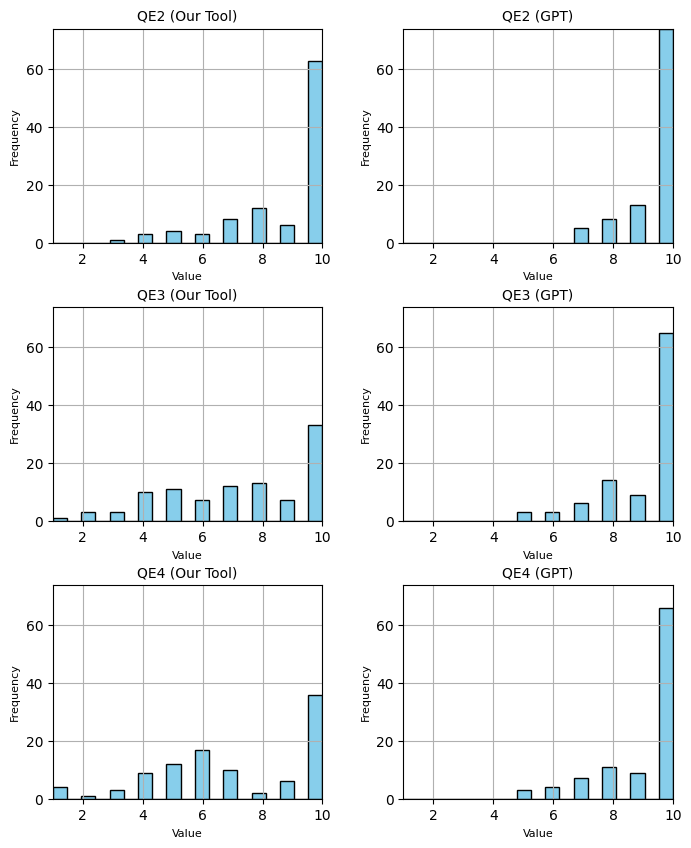

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# List of columns to plot
columns = ["QE2 (Our Tool)", "QE2 (GPT)", "QE3 (Our Tool)", "QE3 (GPT)", "QE4 (Our Tool)", "QE4 (GPT)"]

# Calculate the overall min and max values
overall_min = df[columns].min().min()
overall_max = df[columns].max().max()

# Define the number of bins
num_bins = 20  # Adjust as needed for desired width

# Create a common bin range
bins = np.linspace(overall_min, overall_max, num_bins)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))  # Adjust figure size to make plots narrower
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between subplots

# Plot each histogram with the common bins
for ax, column in zip(axs.flatten(), columns):
    df.hist(column=column, ax=ax, color="skyblue", bins=bins, edgecolor='black')  # Use common bins
    ax.set_title(column, fontsize=10)
    ax.set_xlabel('Value', fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)

# Set same scale for all histograms
y_max = df[columns].apply(pd.Series.value_counts).max().max()

for ax in axs.flatten():
    ax.set_xlim(overall_min, overall_max)
    ax.set_ylim(0, y_max)

# Save the figure as a PDF
plt.savefig('histograms.pdf', format='pdf', bbox_inches='tight')

#plt.savefig('histograms.jpg', format='jpg', bbox_inches='tight', dpi=300)

plt.show()


In [5]:
average_values = df[columns].mean()

In [6]:
average_values

QE2 (Our Tool)    8.89
QE2 (GPT)         9.56
QE3 (Our Tool)    7.34
QE3 (GPT)         9.18
QE4 (Our Tool)    7.13
QE4 (GPT)         9.17
dtype: float64

In [9]:
value_counts_A = df['QE1 (GPT)'].value_counts()
value_counts_A

QE1 (GPT)
y    100
Name: count, dtype: int64

In [10]:
value_counts_A = df['QE1(Our Tool)'].value_counts()
value_counts_A

QE1(Our Tool)
y    87
n    13
Name: count, dtype: int64

In [13]:
value_counts_A = df['QE5 (GPT)'].value_counts()
value_counts_A


QE5 (GPT)
y    84
n    16
Name: count, dtype: int64

In [14]:
value_counts_A = df['QE5 (Our Tool)'].value_counts()
value_counts_A

QE5 (Our Tool)
y    72
n    28
Name: count, dtype: int64